In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
with open('T_T100D_SEGMENT_US_CARRIER_ONLY-2022-11.csv', 'r') as file:
    df1 = pd.read_csv(file, low_memory=False)


In [31]:
data = df1[['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
          'PASSENGERS', 
          'UNIQUE_CARRIER', 'UNIQUE_CARRIER_NAME',
            'CARRIER', 'CARRIER_NAME',
            'ORIGIN',
          'ORIGIN_CITY_NAME', 
          'ORIGIN_STATE_NM',  
            'DEST', 'DEST_CITY_NAME',  
           'DEST_STATE_NM', 
            'YEAR', 'QUARTER',
          'MONTH', 'DISTANCE_GROUP', 'CLASS']].copy()
# calculate load factor and PDEW
data['LOAD_FACTOR'] = round(data['PASSENGERS'] / data['SEATS'] * 100, 2)
data['PDEW'] = round(data['PASSENGERS'] / 30, 2)
data.replace([np.inf, -np.inf], -1, inplace=True)
df = data.loc[data.ORIGIN == 'SFO'].loc[data.MONTH == 11]


In [32]:
# ranks by PDEW from SFO to top ten destination on Nov
city_data = data[data.MONTH == 11]
sfo = city_data.loc[data.ORIGIN == 'SFO']

sfo_data = sfo[[
            'CARRIER', 
             'ORIGIN',
             'ORIGIN_CITY_NAME',
             'DEST', 'DEST_CITY_NAME',
             'MONTH',  'LOAD_FACTOR', 'PDEW']].copy()
# group PDEW by destination airport code
sums = sfo_data.groupby('DEST').agg(
    {'PDEW': 'sum', 'ORIGIN': 'first', 'DEST_CITY_NAME': 'first'}).reset_index()



In [33]:
# read airport location data
with open('us-airports.csv', 'r', encoding="utf8") as file:
    airports = pd.read_csv(file)

airport_location = airports[['iata_code', 'latitude_deg', 'longitude_deg']].copy()

airport_location=airport_location.rename(columns={'iata_code': 'DEST'})
airport_location.dropna(inplace=True)
# drop row 0
airport_location.drop(index=0, inplace=True)


In [34]:
# merge sums and airport location 
sums = pd.merge(sums, airport_location, how='left')
sfo_top_ten = sums.sort_values(by='PDEW', ascending=False).head(10)
# combine lat and lon coordinates
sfo_top_ten['DEST_LOC'] = sfo_top_ten.apply(
    lambda x: [float(x['longitude_deg']), float(x['latitude_deg'])], axis=1)
sfo_top_ten = sfo_top_ten.drop(['latitude_deg', 'longitude_deg'], axis=1)
# add one column with sfo coodinates
sfo_top_ten["ORG_LOC"] = [[-122.389977, 37.615223]]*len(sfo_top_ten)



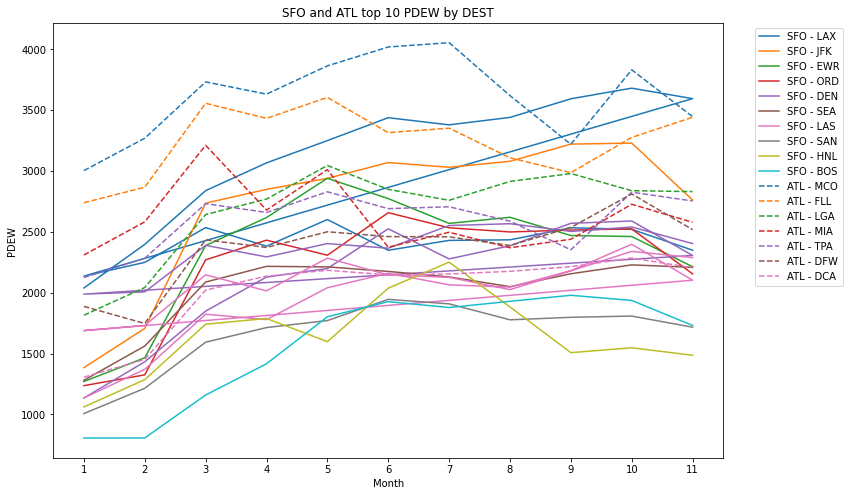

In [35]:
# Plot and compare two airports top ten DEST by PDEW
def query_org(airport_code):
    city_data = data[data.ORIGIN == airport_code].sort_values(['PDEW'], ascending=False)
    return city_data

def pivot_org(data, category):
    data_pivot = round(pd.pivot_table(data, columns=['MONTH'], index=[category], values=['PDEW'], aggfunc='sum', margins=True, margins_name='Total').dropna(), 2)
    rank = data_pivot['PDEW'].sort_values(by='Total', ascending=False).drop('Total')
    return rank

def plot(data, airport_code1, airport_code2, category, linestyle1, linestyle2):
    A = data.drop('Total', axis=1)
    A = A.T
    plt.ylabel('PDEW')
    plt.xlabel('Month')
    plt.xticks([i for i in range(1, 13)])
    
    # Plot for the first airport code
    for i in A.columns[:10]:
        plt.plot(A.index, A[i], label=f'{airport_code1} - {A[i].name}', linestyle=linestyle1)

    # Plot for the second airport code
    for i in A.columns[10:]:
        plt.plot(A.index, A[i], label=f'{airport_code2} - {A[i].name}', linestyle=linestyle2)

    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.04, 1))
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.title(f'{airport_code1} and {airport_code2} top 10 PDEW by {category}')
    plt.show()

linestyle1 = 'solid'
linestyle2 = 'dashed'
airport_code1 = 'SFO'
airport_code2 = 'ATL'
category = 'DEST'

# Query and pivot for the first airport
city1 = query_org(airport_code1)
res1 = pivot_org(city1, category)
top1 = res1.head(10)

# Query and pivot for the second airport
city2 = query_org(airport_code2)
res2 = pivot_org(city2, category)
top2 = res2.head(10)

# Combine the top 10 data from both airports
combined_top = pd.concat([top1, top2], axis=1)
plot(combined_top, airport_code1, airport_code2, category, linestyle1, linestyle2)


In [36]:
# City pair pax per day table
city_pair = data.query(
    """ (`ORIGIN` == 'SFO' or `ORIGIN` == 'SJC') and `DEST` == 'LAX' and `CLASS` == 'F' """)

data_pivot = round(pd.pivot_table(city_pair, columns=['MONTH'], index=['ORIGIN',
     'CARRIER_NAME'], values=['PDEW'], aggfunc='sum', margins=True, margins_name='Total'), 2)
rank = data_pivot['PDEW'].sort_values(
    by=['ORIGIN', 'Total'], ascending=False)
rank.drop('Total', level=0)


MONTH                               1       2        3        4        5  \
ORIGIN CARRIER_NAME                                                        
SFO    United Air Lines Inc.   622.63  758.70   956.18   959.31   904.35   
       SkyWest Airlines Inc.   731.17  735.16  1009.40  1058.64  1163.87   
       Southwest Airlines Co.  234.30  286.77   383.83   564.70   587.53   
       Delta Air Lines Inc.      6.80     NaN      NaN      NaN      NaN   
       Alaska Airlines Inc.    250.63  372.78   339.41   241.83   344.00   
       JetBlue Airways         128.43  155.63   141.00   240.13   249.87   
       American Airlines Inc.   56.87   86.00     6.93      NaN      NaN   
       Horizon Air               7.90     NaN      NaN      NaN      NaN   
BNA    Delta Air Lines Inc.    114.60  119.80   300.00   338.20   320.80   
       Southwest Airlines Co.  221.56  246.23   157.50   284.90   315.30   
       American Airlines Inc.  137.57  130.93   150.80   155.34   173.20   
       Spirit Air Lines         76.20   63.60    71.53    68.93   102.20   
       JetBlue Airways            NaN     NaN      NaN      NaN     5.23   
       SkyWest Airlines Inc.      NaN     NaN      NaN      NaN      NaN   

MONTH                                6        7        8        9       10  \
ORIGIN CARRIER_NAME                                                          
SFO    United Air Lines Inc.   1049.29  1161.22  1205.33  1084.66  1114.71   
       SkyWest Airlines Inc.   1005.93   887.20   865.87   819.93   839.57   
       Southwest Airlines Co.   592.33   569.77   577.27   549.63   571.57   
       Delta Air Lines Inc.     320.83   340.46   370.47   654.24   808.81   
       Alaska Airlines Inc.     321.06   169.12   171.40   146.52    67.63   
       JetBlue Airways          144.73   245.46   247.76   324.53   273.87   
       American Airlines Inc.      NaN      NaN      NaN      NaN      NaN   
       Horizon Air                 NaN      NaN      NaN     2.50      NaN   
BNA    Delta Air Lines Inc.     318.87   322.47   316.66   318.07   347.67   
       Southwest Airlines Co.   161.74   143.83   148.23   277.89   307.16   
       American Airlines Inc.   123.13   121.94   115.73   130.10   140.00   
       Spirit Air Lines         152.00   149.37   125.93   128.30   159.70   
       JetBlue Airways             NaN      NaN      NaN      NaN      NaN   
       SkyWest Airlines Inc.       NaN      NaN      NaN      NaN     0.00   

MONTH                               11     Total  
ORIGIN CARRIER_NAME                               
SFO    United Air Lines Inc.   1120.24  10936.62  
       SkyWest Airlines Inc.    628.97   9745.71  
       Southwest Airlines Co.   529.20   5446.90  
       Delta Air Lines Inc.     753.57   3255.18  
       Alaska Airlines Inc.     147.13   2571.51  
       JetBlue Airways          293.70   2445.11  
       American Airlines Inc.   114.43    264.23  
       Horizon Air                 NaN     10.40  
BNA    Delta Air Lines Inc.     366.00   3183.14  
       Southwest Airlines Co.   292.63   2556.97  
       American Airlines Inc.   144.80   1523.54  
       Spirit Air Lines         140.86   1238.62  
       JetBlue Airways             NaN      5.23  
       SkyWest Airlines Inc.       NaN      0.00

F - Schedule Passenger Service
(includes Freight/Mail in the Belly)
G - Scheduled ALL Cargo Service
(NO Passengers)
L - Non-Scheduled Passenger Service
(includes Freight/Mail in the Belly)
N - Non-Scheduled Military Passenger Service by U.S. Carriers
(includes Freight/Mail in the Belly)
P - Non-Scheduled ALL Cargo Service
(NO Passengers)
R - Non-Scheduled Military ALL Cargo Service by U.S. Carriers
(NO Passengers)
Q - Non-Scheduled Services by Foreign Carriers
(Other than Charter) 